In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn

import torch.optim as optim 
from torch.utils.data import DataLoader 
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# Set up for getting reproducibility of result
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
# Hyperparameters
input_size = 3 * 32 * 32
n_classes = 10
learning_rate = 0.001
batch_size = 64
n_epochs = 50

In [7]:
# Load CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='/content/drive/MyDrive/Datasets/CIFAR10', train=True, 
                                                       transform=transforms.ToTensor(), download=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = datasets.CIFAR10(root='/content/drive/MyDrive/Datasets/CIFAR10', train=False, 
                                                    transform=transforms.ToTensor(), download=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/MyDrive/Datasets/CIFAR10
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/Datasets/CIFAR10
    Split: Test
    StandardTransform
Transform: ToTensor()

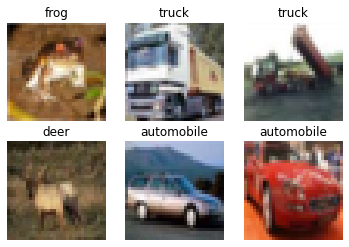

In [18]:
classes =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(6):
    image, label = train_dataset[i]
    plt.subplot(2,3,i+1)
    plt.title(classes[label])
    plt.axis('off')
    plt.imshow(image.permute(1,2,0), cmap='gray')


In [ ]:
class MLP(nn.Module):
  def __init__(self, input_size, n_classes):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features=input_size, out_features=1024),
        nn.ReLU(),
        nn.Linear(in_features=1024, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=n_classes),
        nn.Softmax(dim=1)
    )

  def forward(self, X):
    prob = self.model(X)
    return prob


In [ ]:
model = MLP(input_size=input_size, n_classes=n_classes).to(device)
model

MLP(
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
    (9): Softmax(dim=1)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(n_epochs):
  for batch_idx, (images, labels) in enumerate(train_loader):
    # Get data to GPU
    images = images.to(device)
    labels = labels.to(device)

    # Reshape
    images = images.reshape(images.shape[0], -1)

    # Forward pass
    z_scores = model(images)
    loss = criterion(z_scores, labels)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Gradient descent
    optimizer.step()

    if(batch_idx + 1) % 100 == 0:
      print(f'Epoch {epoch+1}/{n_epochs}, Batch {batch_idx+1}, Loss: {loss.item():.4f}')

Epoch 1/50, Batch 100, Loss: 2.2170
Epoch 1/50, Batch 200, Loss: 2.2323
Epoch 1/50, Batch 300, Loss: 2.1394
Epoch 1/50, Batch 400, Loss: 2.2219
Epoch 1/50, Batch 500, Loss: 2.2086
Epoch 1/50, Batch 600, Loss: 2.1606
Epoch 1/50, Batch 700, Loss: 2.1741
Epoch 2/50, Batch 100, Loss: 2.1472
Epoch 2/50, Batch 200, Loss: 2.1634
Epoch 2/50, Batch 300, Loss: 2.1775
Epoch 2/50, Batch 400, Loss: 2.1516
Epoch 2/50, Batch 500, Loss: 2.1095
Epoch 2/50, Batch 600, Loss: 2.1108
Epoch 2/50, Batch 700, Loss: 2.1466
Epoch 3/50, Batch 100, Loss: 2.0731
Epoch 3/50, Batch 200, Loss: 2.1527
Epoch 3/50, Batch 300, Loss: 2.0559
Epoch 3/50, Batch 400, Loss: 2.0761
Epoch 3/50, Batch 500, Loss: 2.0831
Epoch 3/50, Batch 600, Loss: 2.0766
Epoch 3/50, Batch 700, Loss: 2.0686
Epoch 4/50, Batch 100, Loss: 2.1024
Epoch 4/50, Batch 200, Loss: 2.1914
Epoch 4/50, Batch 300, Loss: 2.0495
Epoch 4/50, Batch 400, Loss: 2.1604
Epoch 4/50, Batch 500, Loss: 2.1742
Epoch 4/50, Batch 600, Loss: 2.1070
Epoch 4/50, Batch 700, Loss:

In [ ]:
def get_accuracy(loader, model):
  if loader.dataset.train:
    print('Getting accuracy on trainning data')
  else:
    print('Getting accuracy on testing data')

  n_corrects = 0
  n_samples = 0

  # Put model to evalution mode
  model.eval()

  with torch.no_grad():
    for images, labels in loader:
      images = images.to(device)
      labels = labels.to(device)

      images = images.reshape(images.shape[0], -1)

      z_scores = model(images)

      _, y_pred = z_scores.max(1)
      n_corrects += (y_pred == labels).sum()
      n_samples += y_pred.size(0)

    print(f'We got {n_corrects}/{n_samples} correct')
    print(f'Accuracy =  {float(n_corrects) / float(n_samples)*100.0:.2f}')
  # Put model to train mode
  model.train()

In [ ]:
get_accuracy(train_loader, model)
get_accuracy(test_loader, model)

Getting accuracy on trainning data
We got 21635/50000 correct
Accuracy =  43.27
Getting accuracy on testing data
We got 4230/10000 correct
Accuracy =  42.30
